In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import time_of_emergence as toe

import warnings; warnings.simplefilter('ignore')

In this notebook we generate clusters for further analysis.

# Load Data

Load the following data sources: 

1. Regressions b/t temperature and O3
2. Seasonal cycle for all fields
3. landsea mask

In [5]:
from darpy import landsea_mask
from air_quality.util import shift_roll

monthly_regress = (
    xr.open_dataset("../data/processed/fgm.O3_SRF-vs-TREFHT.monthly.ensemble_mean.nc")
    # .pipe(shift_roll)
)
monthly_cycle = (
    xr.open_dataset("../data/processed/annual_cycle/fgm.cycle.nc")
    .mean('ic')
    # .pipe(shift_roll)
)
# This can take a very long time to compute; probably need to do this offline form the
# analysis proper.
# monthly_diff = (
#     xr.open_dataset("../data/processed/fgm.air_quality.monthly.nc")
#     .pipe(lambda x: x.sel(dec='2085-2115').groupby('time.month').mean('time') 
#                   - x.sel(dec='1980-2010').groupby('time.month').mean('time'))
#     .mean('ic')
# )

# Get a land/sea continent mask and re-map from boolean to integers
lsm = (
    landsea_mask(monthly_regress)
    .transpose('lat', 'lon')
    .astype('int')
    # .pipe(shift_roll)    
)

# Prepare Data

For clustering, we want to transform the dataset into a form more amenable for analysis - building a design/feature matrix. 

In all of these cases, we'll ignore data from the Southern Ocean and the Arctic.

In [6]:
lat_slice = slice(-50, 70)

def sel_lats(ds):
    return ds.sel(lat=lat_slice)

## Adjacency Matrix

Using the landsea mask as our reference, compute the 2D adjaceny matrix with periodic boundary conditions.

In [7]:
from time_of_emergence.models import periodic_x_connectivity_matrix

_landsea = (
    lsm
    .pipe(sel_lats)
)

conn = periodic_x_connectivity_matrix(*_landsea.shape[::-1], order='F')

_landsea = _landsea.to_dataframe('landsea')

### Annual O3 cycle

In [18]:
_monthly_cycle_data_da = (
    (monthly_cycle['O3_SRF'] * 1e9)
    .pipe(sel_lats)
    .sel(dec='1980-2010', pol='REF')
)
_monthly_cycle_data_df = (
    _monthly_cycle_data_da
    .to_dataframe()[['O3_SRF', ]]
    .unstack('month')['O3_SRF']
    .add_prefix("present_")
)

### Delta O3 cycle

In [19]:
def diff(da, dec1='1980-2010', dec2='2035-2065'):
    return da.sel(dec=dec2) - da.sel(dec=dec1)

_monthly_change_data_da = (
    (monthly_cycle['O3_SRF'] * 1e9)
    .pipe(sel_lats)
    .sel(pol='REF')
    .pipe(diff)
)
_monthly_change_data_df = (
    _monthly_change_data_da
    .to_dataframe()[['O3_SRF', ]]
    .unstack('month')['O3_SRF']
    .add_prefix("change_")
)

### Temperature-O3 regression analysis

In [20]:
rfld = "r_O3_SRF_TREFHT"

_monthly_regress_data_da = (
    monthly_regress[rfld]
    .pipe(sel_lats)
    .sel(dec='1980-2010', pol='REF')
)

_monthly_regress_data_df = (
    _monthly_regress_data_da
    .to_dataframe()[[rfld, ]]
    .unstack('month')[rfld]
    .add_prefix("present_r_")
)

Check data sources

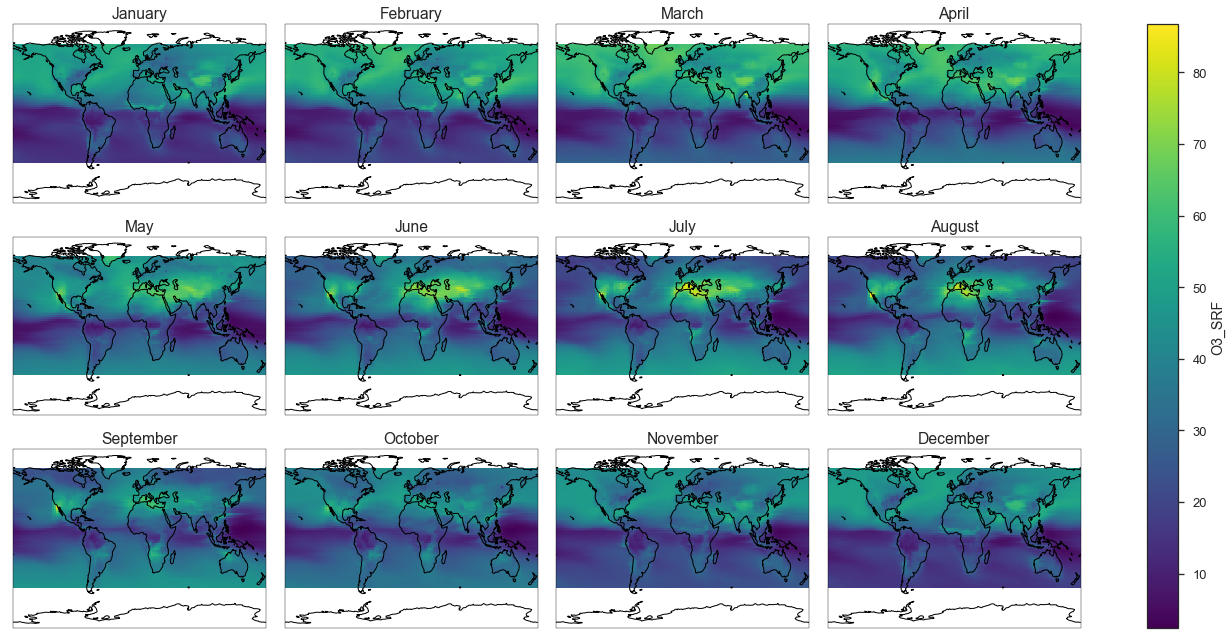

In [23]:
from calendar import month_name

g = _monthly_cycle_data_da.plot.pcolormesh(col='month', col_wrap=4, transform=ccrs.PlateCarree(),
                                           size=3., aspect=1.5,
                                           subplot_kws=dict(projection=ccrs.PlateCarree(), aspect='auto'))

for ax, month in zip(g.axes.ravel(), month_name[1:]):
    ax.set_global()
    ax.coastlines()
    ax.set_title(month)

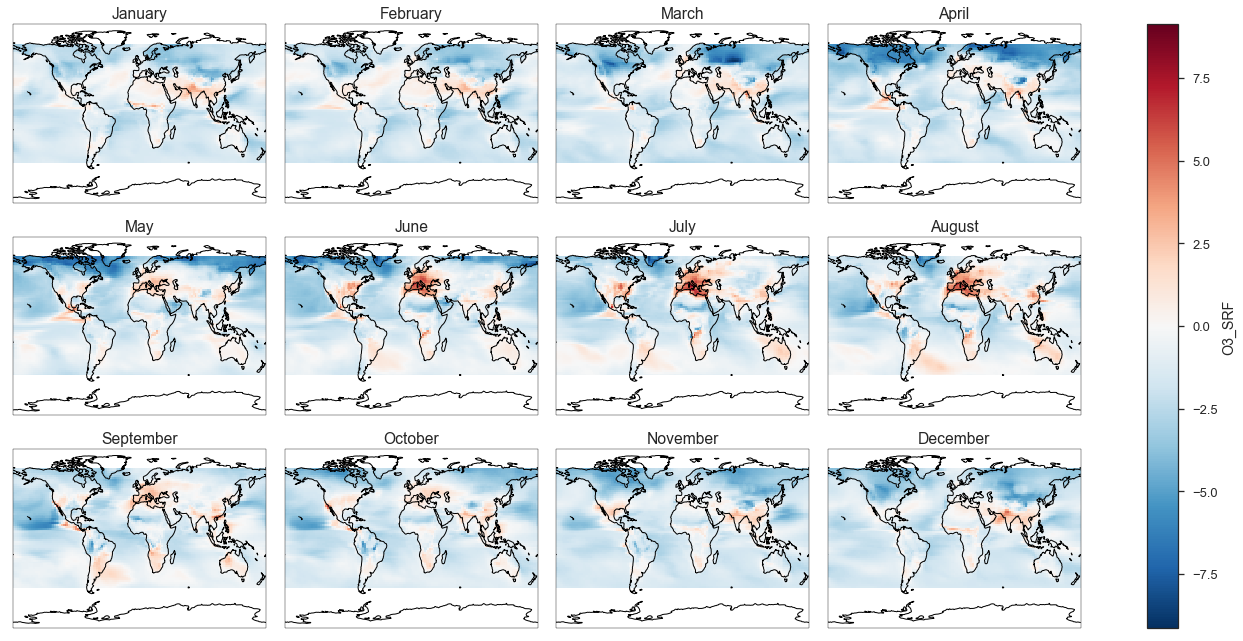

In [24]:
g = _monthly_change_data_da.plot.pcolormesh(col='month', col_wrap=4, transform=ccrs.PlateCarree(),
                                            size=3., aspect=1.5,
                                            subplot_kws=dict(projection=ccrs.PlateCarree(), aspect='auto'))
for ax, month in zip(g.axes.ravel(), month_name[1:]):
    ax.set_global()
    ax.coastlines()
    ax.set_title(month)

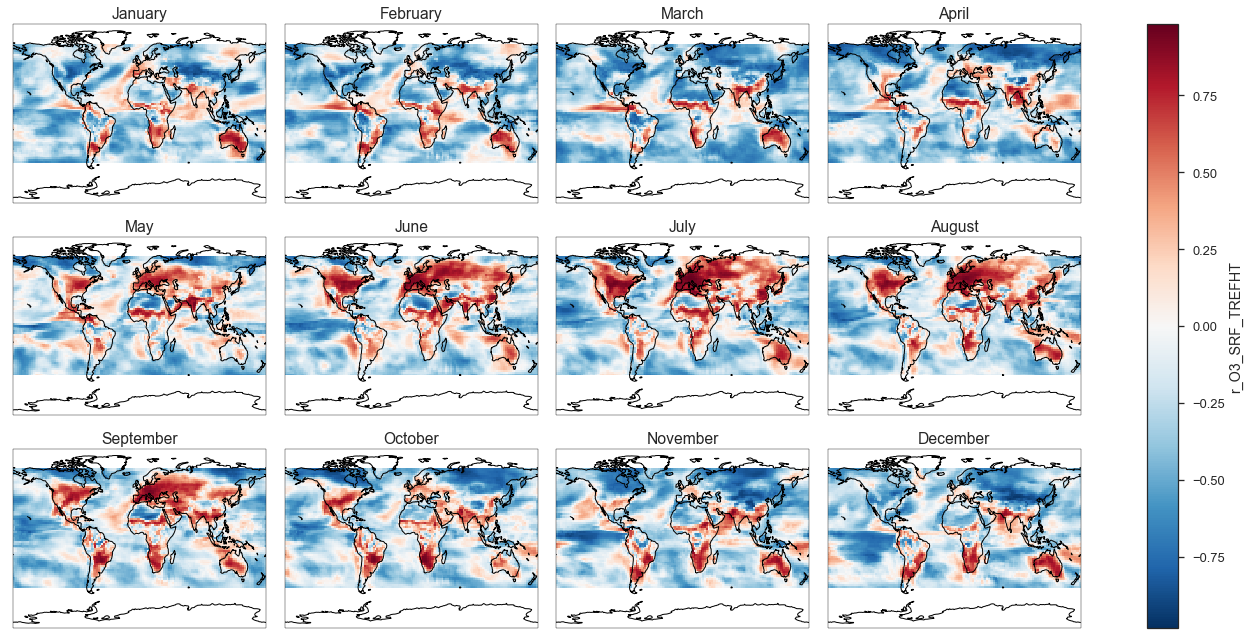

In [25]:
g = _monthly_regress_data_da.plot.pcolormesh(col='month', col_wrap=4, transform=ccrs.PlateCarree(),
                                             size=3., aspect=1.5,
                                             subplot_kws=dict(projection=ccrs.PlateCarree(), aspect='auto'))
for ax, month in zip(g.axes.ravel(), month_name[1:]):
    ax.set_global()
    ax.coastlines()
    ax.set_title(month)

## Combine

Combine the two data sources into a DataFrame.

In [45]:
_clustering_df = pd.concat([
    _monthly_cycle_data_df, 
    _monthly_change_data_df,
    _monthly_regress_data_df,
    _landsea,
], axis=1)


Utility functions to map DataFrames <-> Datasets

In [148]:
from time_of_emergence.util import BackToXarray

ref = _clustering_df.copy().reset_index()[['lon', 'lat', 'landsea']].copy()

def back_to_xarray(y, name='data', mask=None):
    """ mask = ocn/lnd"""
    _df = ref.copy()
    if mask is not None:
        m = 1 if mask == 'ocn' else 0
        _df = _df.where(lambda x: x['landsea'] == m).dropna()
    return (
        _df
        .set_index(['lat', 'lon'])
        .assign(**{name: y})
        .sortlevel()
        .to_xarray()
    )
backer = BackToXarray(ref, mask_field='landsea')

# _clustering_df = _clustering_df.reset_index().drop(['lon', 'lat'], axis=1)
# Example:
# back_to_xarray(_clustering_df['change_6'], mask='ocn')['data'].plot.imshow()
# plt.figure()
# backer(_clustering_df['change_6'], mask_val=1)['data'].plot.imshow()

# Cluster Analysis

## Pre-process 

In [130]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin

from time_of_emergence.sklearn import ValMasker

mapper = DataFrameMapper([
    #(['landsea', ], OneHotEncoder()),
    #(['elev', ], MinMaxScaler()),
    (['present_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    #(['change_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
#     (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler())
],
# default=MinMaxScaler()
)

transformer_pipe = Pipeline([
    ('mask_lnd', ValMasker(mask_val=1)),
    ('dataframe_to_array', mapper)
])

X = transformer_pipe.fit_transform(_clustering_df)
print(X.shape)

(9072, 24)


In [102]:
import seaborn as sns

_cdf = pd.DataFrame(X)#, columns = _clustering_df.columns)
# _cdf.plot(kind='kde', subplots=True, layout=(7, 4))

## Compute clusters

In [110]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

n_clusters = 40

clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', 
                                    connectivity=conn,
                                    compute_full_tree=True)
pred = clusterer.fit_predict(X)
pred_ds = back_to_xarray(pred, 'cluster')
pred_ds['n_clusters'] = n_clusters

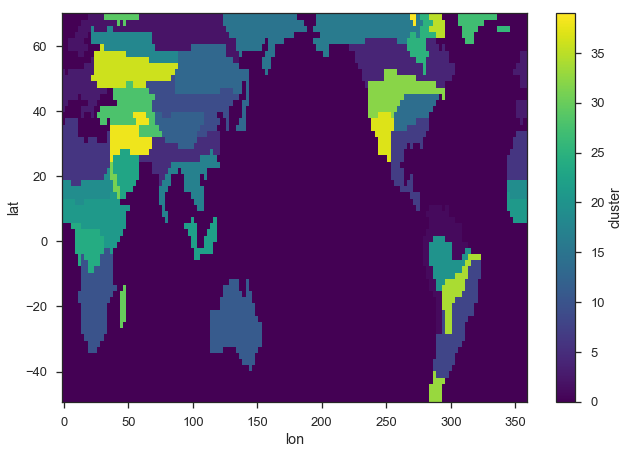

In [111]:
pred_ds.cluster.plot()

### Silhouette score analysis

In [127]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, pdist

# Pre-compute pairwise distances so we only have to do so once
print("Calculating distance matrix...")
met = 'euclidean'
dist = pairwise_distances(X, metric=met, n_jobs=2)

print("Calculating silhouette score...")
# ss = silhouette_score(X, pred)
# sv = silhouette_samples(X, pred)
# ss = silhouette_score(dist, pred, metric='precomputed')
sv = silhouette_samples(dist, pred, metric='precomputed')
ss = np.nanmean(sv[sv > -1])

print("Calculating variance...")

Calculating distance matrix...
Calculating silhouette score...
Calculating variance...


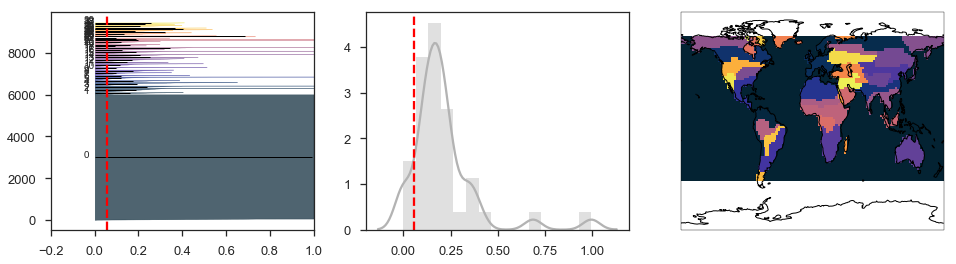

In [309]:
from darpy.plot import get_figsize
import seaborn as sns
import cartopy.crs as ccrs
import cmocean

nrows, ncols = 1, 2
size, aspect = 4., 2.
figsize = get_figsize(nrows, ncols, size, aspect)

cmap = cmocean.cm.thermal

# fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
# ax1, ax2 = axs.ravel()

fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree(), 
                      aspect='auto')

y_lower = 10
silh_avgs = []
for i in range(n_clusters):
    # ith_cluster_silhouette_values = sv[pred == i]
    # ith_cluster_silhouette_values.sort()
    ith_cluster_silhouette_values = np.sort(np.abs(sv[pred == i]))
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cmap(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    
    # Label the silhoutte plots with hteir cluster numbers at hte middle
    y_mid =  y_lower+0.5*size_cluster_i
    ax1.text(-0.05, y_mid, str(i))
    
    # Compute the average silhouette score for this cluster
    silh_avg = np.mean(ith_cluster_silhouette_values)
    if np.isnan(silh_avg):
        silh_avg = 0.
    silh_avgs.append(silh_avg)
    ax1.hlines(y_mid, 0, silh_avg, color='k', lw=1)
    
    # compute hte new y_lower for the next plot
    y_lower = y_upper + 10    
    
# Average score of all the values
ax1.axvline(x=ss, color='red', linestyle='--')
ax1.set_xlim(-0.2, 1.)

# Plot distribution of average silhouette scores
sns.distplot(silh_avgs, ax=ax2, color='0.7')
ax2.axvline(x=ss, color='red', linestyle='--')

# Map of clusters
pred_ds.cluster.plot.pcolormesh(ax=ax3, infer_intervals=True, cmap=cmap, 
                                transform=ccrs.PlateCarree(), add_colorbar=False)
ax3.set_global()
ax3.coastlines()

Check the results using 2D PCA.

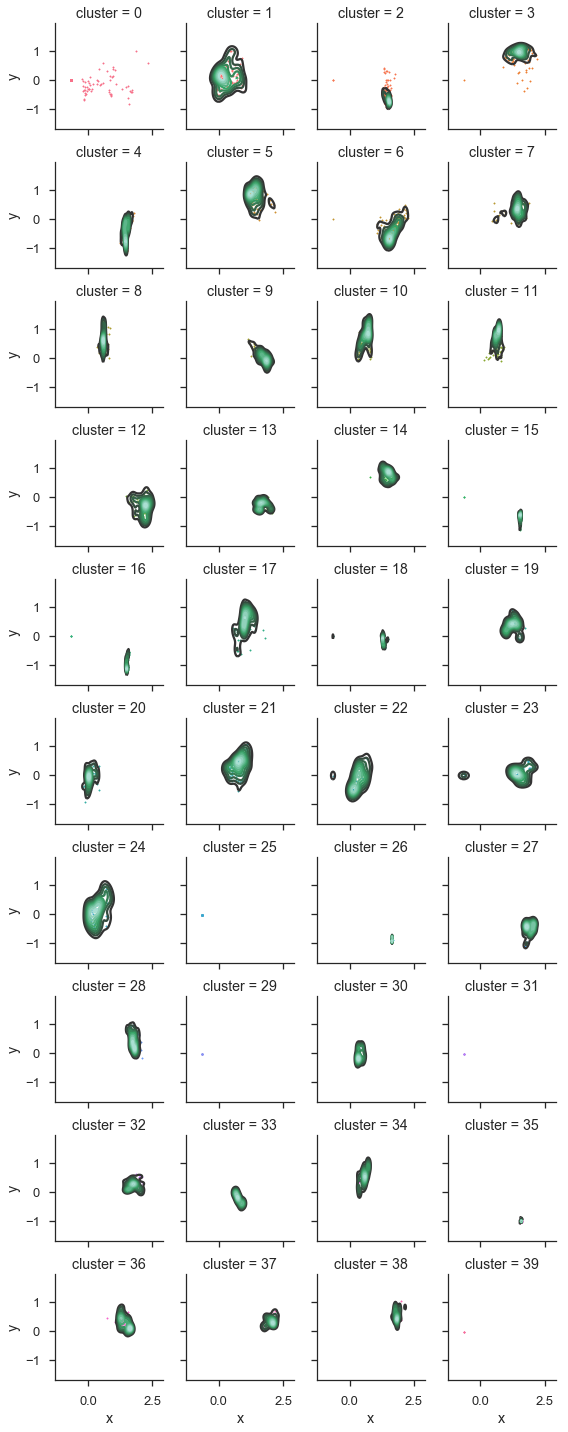

In [129]:
from sklearn.decomposition import PCA
from darpy.plot import get_figsize

pca = PCA(n_components=2)
y_hat = pca.fit_transform(X[:, :])
y_hat = pd.DataFrame(y_hat, columns=['x', 'y'])
y_hat['cluster'] = pred

def _kdeplot(*args, **kwargs):
    try: 
        ax = sns.kdeplot(*args, **kwargs)
    except:
        ax = None
    return ax

g = sns.FacetGrid(y_hat, hue='cluster', col='cluster', col_wrap=4, size=2)
g.map(_kdeplot, 'x', 'y', shade=False)
g.map(plt.scatter, 'x', 'y', s=2)

## Determining `n_clusters`

It's not clear at first-order how many clusters we should use, so our best bet is to try to quantify the performance on many different values of clusters. 

In [344]:
from sklearn.pipeline import Pipeline
from time_of_emergence.sklearn import ValMasker

mapper = DataFrameMapper([
    #(['landsea', ], None),
    (['present_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    (['change_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
    (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
#     (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler())
],
# default=MinMaxScaler()
)

mask = _clustering_df['landsea'].values == 1
transformer_pipe = Pipeline([
    ('dataframe_to_array', mapper),
    ('mask_lnd', ValMasker(mask=mask, mask_val=1)),
])
X = transformer_pipe.fit_transform(_clustering_df)


# Pre-compute distance matrix
met = 'euclidean'
dist = pairwise_distances(X, metric=met, n_jobs=2)

exp = 'exp5'

First, we can look at how the metrics change as we change the number of clusters.

In [345]:
from tqdm import tnrange
from sklearn import metrics as skm

results = []
for n in tnrange(25, 26):
    print(n, end=", ")
    c = AgglomerativeClustering(n_clusters=n, linkage='ward', 
                                connectivity=conn,
                                compute_full_tree=True)
    labels = c.fit_predict(X)
    results.append({
        'n_clusters': n,
        'labels': labels,
        'calinski_harabaz': skm.calinski_harabaz_score(X, labels),
        'silhouette': skm.silhouette_score(X, labels)
    }) 

Widget Javascript not detected.  It may not be installed or enabled properly.


25, 


In [346]:
das = []
for result in results:
    #da = back_to_xarray(result['labels'], 'label')['label']
    da = backer(result['labels'], 'label')['label']
    da['n_clusters'] = result['n_clusters']
    da['silhouette'] = result['silhouette']
    da['calinski_harabaz'] = result['calinski_harabaz']
    das.append(da)
_ds = xr.concat(das, dim='n_clusters')

# _ds.to_netcdf("../results/cluster/labels.{exp}.nc".format(exp=exp))

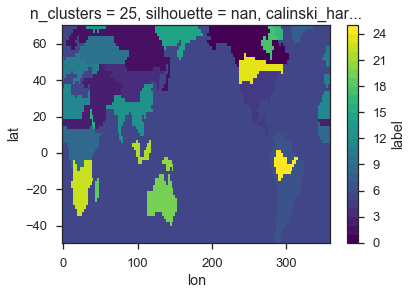

In [347]:
da.plot(levels=range(int(da.n_clusters+1)))

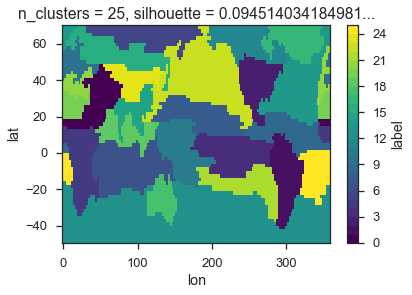

In [339]:
da.plot(levels=range(int(da.n_clusters+1)))

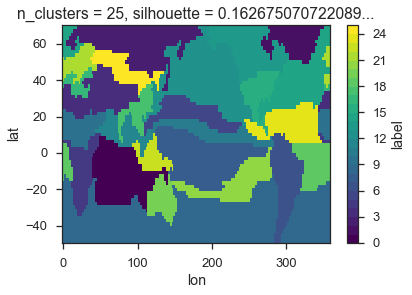

In [332]:
da.plot(levels=range(int(da.n_clusters+1)))

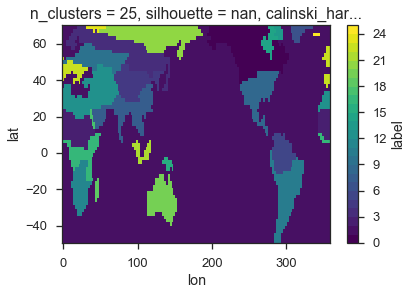

In [314]:
da.plot(levels=range(int(da.n_clusters+1)))

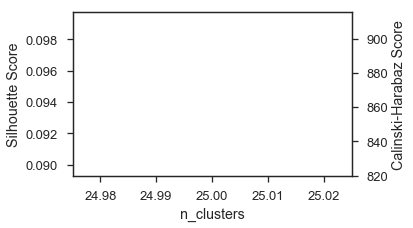

In [341]:
%matplotlib inline

rdf = pd.DataFrame(results)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
rdf.plot('n_clusters', 'silhouette', ax=ax, legend=False)
ax.set_ylabel("Silhouette Score")
ax2 = ax.twinx()
rdf.plot('n_clusters', 'calinski_harabaz', ax=ax2, color='r', legend=False)
ax2.set_ylabel("Calinski-Harabaz Score")

# plt.savefig("../results/cluster/score_vs_nclusters.{exp}.png"
#             .format(exp=exp), dpi=150, transparent=True, bbox_inches='tight')

(63, 144) (9072, 36)
a


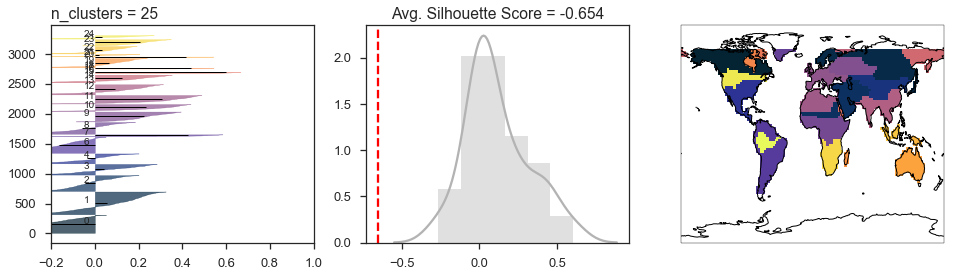

In [402]:
from time_of_emergence.plots import silhouette_cluster_labels
from sklearn.metrics import silhouette_samples

n = 25
labels = _ds.sel(n_clusters=n)
labels_arr = labels.data.ravel()
print(labels.shape, X.shape)

samples = silhouette_samples(dist, labels_arr, metric='precomputed')
fig, axs = silhouette_cluster_labels(samples, labels, n, skip_clusters=[5, ])

In [401]:
labels.where(~poor_isin(labels, [5, ], 'or'))#.plot.pcolormesh()

<xarray.DataArray 'label' (lat: 63, lon: 144)>
array([[ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       ..., 
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.]])
Coordinates:
  * lat               (lat) float64 -48.32 -46.42 -44.53 -42.63 -40.74 ...
  * lon               (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 ...
    silhouette        float64 nan
    calinski_harabaz  float64 3.59e+03
    n_clusters        int64 25

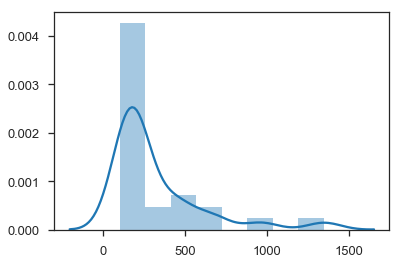

In [322]:
x = _labels_arr.copy()
counts = []
for i in range(n):
    counts.append(len(x[x == i]))
    
sns.distplot(counts)

The next measure we can look at is the relative stability of clusters for a given `n_clusters`. As a simple example, let's generate 10 sets of clusters for n=10.

In [146]:
all_labels = []
n = 10
samples = 10
for _ in tnrange(samples):
    print(_, end=", ")
    c = AgglomerativeClustering(n_clusters=n, linkage='ward', 
                                connectivity=conn,
                                compute_full_tree=True)
    labels = c.fit_predict(X)
    all_labels.append(labels)
all_labels = np.asarray(all_labels)

Widget Javascript not detected.  It may not be installed or enabled properly.


10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 


---

Archive results

In [14]:
!rm "../data/fgm.clusters.test.nc"
pred_ds.to_netcdf("../data/fgm.clusters.test.nc")

Visualize as a sanity check.

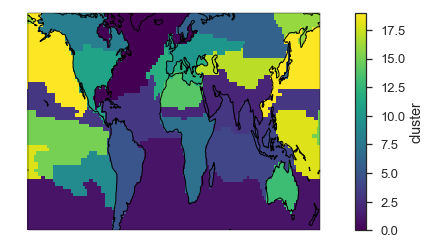

In [301]:
from darpy.plot import get_figsize
from darpy.utilities import shift_roll
import cartopy.crs as ccrs

size, aspect = 4., 1.8
figsize = get_figsize(1, 1, size, aspect)
fig, ax = plt.subplots(1, 1, figsize=figsize,
                        subplot_kw=dict(projection=ccrs.PlateCarree(),
                                        aspect='auto'))

pred_ds.cluster.plot.pcolormesh(ax=ax, infer_intervals=True, transform=ccrs.PlateCarree())
ax.coastlines()